In [1]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [2]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [3]:
import cv2
import tarfile
from pathlib import Path
from tqdm import tqdm
import shutil
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers as tfl
from tensorflow.keras.layers import *
from tensorflow_addons.image import transform as H_transform
import matplotlib.pyplot as plt
import os, datetime

from models.utils import shared_encoder, detector_head, descriptor_head, detector_loss, descriptor_loss, model_metrics, box_nms
from utils.tools import dict_update

import numpy as np

In [4]:
!pwd

/root/Internship-Valeo/Project


In [5]:
DATA_PATH = '/root/Internship-Valeo/Project/data'

In [6]:
from datasets import synthetic_dataset
from datasets.utils import pipeline
from datasets.utils.pipeline import parse_primitives
from datasets.utils import photometric_augmentation as photaug
from models.homographies import (sample_homography, compute_valid_mask,
                                            warp_points, filter_points)

In [7]:
default_config = {
        'labels': None,
        'cache_in_memory': False,
        'validation_size': 100,
        'truncate': None,
        'preprocessing': {
            'resize': [240, 320]
        },
        'num_parallel_calls': 10,
        'augmentation': {
            'photometric': {
                'enable': False,
                'primitives': 'all',
                'params': {},
                'random_order': True,
            },
            'homographic': {
                'enable': False,
                'params': {},
                'valid_border_margin': 0,
            },
        },
        'warped_pair': {
            'enable': False,
            'params': {},
            'valid_border_margin': 0,
        },
    }

In [8]:
import yaml
with open('/root/Internship-Valeo/Project/configs/superpoint_coco.yaml', 'r') as stream:
    config = yaml.safe_load(stream)

In [9]:
config1 = config
config = dict_update(default_config, config['data'])

In [10]:
default_model_config = {
            'data_format': 'channels_first',
            'grid_size': 8,
            'detection_threshold': 0.4,
            'descriptor_size': 256,
            'batch_size': 32,
            'learning_rate': 0.001,
            'lambda_d': 250,
            'descriptor_size': 256,
            'positive_margin': 1,
            'negative_margin': 0.2,
            'lambda_loss': 0.0001,
            'nms': 0,
            'top_k': 0,
    }

In [11]:
model_config = dict_update(default_model_config, config1['model'])

In [12]:
model_config['data_format'] = 'channels_last'

In [13]:
logdir = "logs/scalars/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [14]:
from datasets import coco
data = coco.Coco()
files = data._init_dataset(**config)
train_gen = data._get_data(files, 'training', **config)
val_gen = data._get_data(files, 'validation', **config)

In [15]:
# # code for photometric augmentation

# primitives_photo = parse_primitives(config['augmentation']['photometric']['primitives'], photaug.augmentations)

# prim_configs = [config['augmentation']['photometric']['params'].get(p, {}) for p in primitives_photo]

# indices = tf.range(len(primitives_photo))
# if config['augmentation']['photometric']['random_order']:
#     indices = tf.random.shuffle(indices)
# def photo_aug_step(i, image):
#     fn_pairs = [(tf.equal(indices[i], j), lambda p=p, c=c: getattr(photaug, p)(image, **c))
#                 for j, (p, c) in enumerate(zip(primitives_photo, prim_configs))]
#     image = tf.case(fn_pairs)
#     return i + 1, image

In [16]:
# # read keypoints
# def _read_points(filename):
#     print(filename)
#     np.load(Path(filename))['points'].astype(np.float32)
# #     return np.load(filename).astype(np.float32)

In [17]:
# class DataGen(keras.utils.Sequence):
#     def __init__(self, image_path, point_path, #homography_path, 
# #                  warped_image_path, warped_point_path, 
#                  image_size_x = 320, image_size_y = 240,
#                  is_training = True, batch_size = model_config['batch_size']):
        
#         self.__ids = os.listdir(image_path)
#         self.__image_path = image_path
#         self.__point_path = point_path
# #         self.__homography_path = homography_path
        
# #         self.__warped_image_path = warped_image_path
# #         self.__warped_point_path = warped_point_path
        
#         self.__image_size_x = image_size_x
#         self.__image_size_y = image_size_y
#         self.__batch_size = batch_size
#         self.__is_training = is_training
#         self.on_epoch_end()
        
#     def __getitem__(self, index):
#         images = []
#         points_maps = []
#         points_list = []
        
#         homography_list = []
        
#         warped_images = []
#         warped_points_maps = []
#         warped_points_list = []
        
#         valid_masks = []
        
#         if (index + 1)*self.__batch_size > len(self.__ids):
#             self.__batch_size = len(self.__ids) - index * self.__batch_size
            
#         file_batch = self.__ids[index * self.__batch_size : (index + 1) * self.__batch_size]
        
#         for id_name in file_batch:
#             img_file = os.path.join(self.__image_path, id_name)
#             image = cv2.imread(img_file, 0)
#             image = cv2.resize(image , (self.__image_size_x , self.__image_size_y))
#             image = np.expand_dims(image, axis = 2)
#             image_shape = tf.shape(image)[:2]
            
#             id_name = id_name.replace('.jpg','')
            
# #             point_file = os.path.join(self.__point_path, id_name)
#             point_file = os.path.join(self.__point_path,'{}.npz'.format(id_name))
#             points = _read_points(point_file)
#             print(points)
# #             points = np.round(points).astype(int)
    
            
#             if self.__is_training:
#                 # add photometric_augmentation
#                 _, image = tf.while_loop(lambda i, image: tf.less(i, len(primitives_photo)),
#                                  photo_aug_step, [0, image], parallel_iterations=1)              
                
#                 # read homography file
# #                 homography_file = os.path.join(self.__homography_path, id_name+'.npy')
# #                 homography = _read_points(homography_file)
#                 homography = sample_homography(image_shape, config['warped_pair']['params'])[0]
                
#                 # read warped image
# #                 warped_img_file = os.path.join(self.__warped_image_path,id_name)
# #                 warped_image = cv2.imread(warped_img_file, 0)        
#                 warped_image = H_transform(image, homography, interpolation='BILINEAR')
#                 # compute valid mask
#                 valid_mask = compute_valid_mask(image_shape, homography,
#                                          config['warped_pair']['valid_border_margin'])
                
#                 # read warped points
# #                 warped_point_file = os.path.join(self.__warped_point_path,id_name+'.npy')
# #                 warped_points = _read_points(warped_point_file)
#                 warped_points = warp_points(points, homography)
#                 warped_points = filter_points(warped_points, image_shape)
# #                 warped_points = np.round(warped_points).astype(int)
    
#                 warped_kp = tf.minimum(warped_points, image_shape-1)
#                 warped_points_map = tf.scatter_nd(warped_kp, tf.ones([tf.shape(warped_kp)[0]], 
#                                                                      dtype=tf.int32), image_shape)
                        
                
#                 homography_list.append(homography)
#                 warped_image = warped_image / 255.0
#                 warped_images.append(warped_image)
#                 valid_masks.append(valid_mask)
#                 warped_points_list.append(warped_points)
#                 warped_points_maps.append(warped_points_map)

#             kp = tf.minimum(points, image_shape-1)
#             points_map = tf.scatter_nd(kp, tf.ones([tf.shape(kp)[0]], dtype=tf.int32), image_shape)
            
#             image = image / 255.0
#             images.append(image)
            
#             points_maps.append(points_map)
#             points_list.append(points)
            
            
            
#         images = np.array(images)
#         if self.__is_training:
#             warped_images = np.array(warped_images)
#             homography_list = np.array(homography_list)
#             warped_images = np.array(warped_images)
#             valid_masks = np.expand_dims(valid_masks, axis = 3)
#             dummy_loss_target = np.zeros(self.__batch_size)
#             points_maps = np.expand_dims(points_maps, axis = 3)
#             warped_points_maps = np.expand_dims(warped_points_maps, axis = 3)
#             return [images, 
#                     homography_list, 
#                     warped_images, 
#                     valid_masks, 
#                     points_maps,
#                     warped_points_maps], [dummy_loss_target, dummy_loss_target, dummy_loss_target]
   
           
#     def __len__(self):
#         return int(np.ceil(len(self.__ids) / float(self.__batch_size)))
    
#     def on_epoch_end(self):
#         pass

In [18]:
class HomographyLayer(Layer):
    def call(self, inputs):
        return inputs

def HomographyModel(shape = (8,)):
    x = Input(shape)
    output = HomographyLayer(name="homography_layer", trainable=False)(x)
    return keras.models.Model(inputs = x, outputs = output)

class DescriptorLossLayer(Layer):
    def __init__(self, name='descriptor_loss_layer', trainable=False):
        super(DescriptorLossLayer, self).__init__(name=name)
        self.loss_fn = descriptor_loss
#         self.accuracy_fn = keras.metrics.BinaryAccuracy(name="accuracy")

    def call(self, inputs, targets=None, sample_weight=None):
        loss = model_config['lambda_loss'] * self.loss_fn(descriptors = inputs[0], 
                                                          warped_descriptors = inputs[1],
                            homographies = inputs[2], valid_mask = inputs[3], **model_config)
        self.add_loss(loss)
#         return tf.reshape(loss, (1,))
        return loss
    def compute_output_shape(self, input_shape):
        return [1]
    
class DetectorLossLayer(Layer):
    def __init__(self, name='detector_loss_layer', trainable=False):
        super(DetectorLossLayer, self).__init__(name=name)
        self.loss_fn = detector_loss
        self.metrics_fn = model_metrics
#         self.accuracy_fn = keras.metrics.BinaryAccuracy(name="accuracy")

    def call(self, inputs, targets=None, sample_weight=None):
        loss = self.loss_fn(keypoint_map = inputs[0], logits = inputs[1]['logits'], 
                            valid_mask = inputs[2], model_config = model_config)
        
        if model_config['nms']:
            prob = tf.map_fn(lambda p: box_nms(p, model_config['nms'],
                                               min_prob=model_config['detection_threshold'],
                                               keep_top_k=model_config['top_k']), inputs[1]['prob'])
        pred = tf.cast(tf.greater_equal(prob, model_config['detection_threshold']), tf.float32)
        
        metrics = self.metrics_fn(inputs[0], pred)
        self.add_loss(loss)
        self.add_metric(metrics['precision'], name = 'detector_precision')
        self.add_metric(metrics['recall'], name = 'detector_recall')
        return loss
    def compute_output_shape(self, input_shape):
        return [1]

class WarpedDetectorLossLayer(Layer):
    def __init__(self, name='warped_detector_loss_layer', trainable=False):
        super(WarpedDetectorLossLayer, self).__init__()
        self.loss_fn = detector_loss
        self.metrics_fn = model_metrics
#         self.accuracy_fn = keras.metrics.BinaryAccuracy(name="accuracy")

    def call(self, inputs, targets=None, sample_weight=None):
        loss = self.loss_fn(keypoint_map = inputs[0], logits = inputs[1]['logits'], 
                            valid_mask = inputs[2], model_config = model_config)
        if model_config['nms']:
            prob = tf.map_fn(lambda p: box_nms(p, model_config['nms'],
                                               min_prob=model_config['detection_threshold'],
                                               keep_top_k=model_config['top_k']), inputs[1]['prob'])
        pred = tf.cast(tf.greater_equal(prob, model_config['detection_threshold']), tf.float32)
        
        metrics = self.metrics_fn(inputs[0], pred, valid_mask = inputs[2])
        self.add_loss(loss)
        self.add_metric(metrics['precision'], name = 'warped_detector_precision')
        self.add_metric(metrics['recall'], name = 'warped_detector_recall')
        return loss
    def compute_output_shape(self, input_shape):
        return [1]
    
def net():
    inputs = {'image':Input(shape = (240, 320, 1), name = 'image'),
              'name': Input(shape = (None,1), name = 'name'),
              'keypoints':Input(shape = (240,320), name = 'keypoints'),              
              'valid_mask':Input(shape = (240,320), name = 'valid_mask'),
              'warped':{
                  'image':Input(shape = (240, 320, 1), name = 'warped_image'),
                  'name': Input(shape = (None,1), name = 'warped_name'),
                  'keypoints':Input(shape = (240, 320), name = 'warped_keypoints'),
                  'valid_mask':Input(shape = (240, 320), name = 'warped_valid_mask'),
                  'homography':Input(shape = (8,), name = 'homography'),
               }}

#     inputs = OrderedDict((('image',Input(shape = (240, 320, 1), name = 'image')),
#               ('name', Input(shape = (), name = 'name')),
#               ('keypoints',Input(shape = (240,320), name = 'keypoints')),              
#               ('valid_mask',Input(shape = (240,320), name = 'valid_mask')),
#               ('warped',OrderedDict((
#                   ('image',Input(shape = (240, 320, 1), name = 'warped_image')),
#                   ('name', Input(shape = (), name = 'warped_name')),
#                   ('keypoints',Input(shape = (240, 320), name = 'warped_keypoints')),
#                   ('valid_mask',Input(shape = (240, 320), name = 'warped_valid_mask')),
#                   ('homography',Input(shape = (8,), name = 'homography')),))
#               )))

#     images_input = Input(shape = (240, 320,1), name = 'image')
#     points_maps_input = Input(shape = (240, 320), name = 'keypoints')
#     homography_list_input = Input(shape = (8,), name = 'homography') 
#     warped_images_input = Input(shape = (240, 320, 1), name = 'warped_image')

#     valid_masks_input = Input(shape = (240, 320), name = 'warped_valid_mask')
#     warped_points_maps_input = Input(shape = (240, 320), name = 'warped_keypoints')
    
    if model_config['data_format'] == 'channels_first':
#         images_input = tf.transpose(images_input, [0, 3, 1, 2])
        inputs['image'] = tf.transpose(inputs['image'], [0, 3, 1, 2])
#         warped_images_input = tf.transpose(warped_images_input, [0, 3, 1, 2])
        inputs['warped']['image'] = tf.transpose(inputs['warped']['image'], [0, 3, 1, 2])
    homography_model = HomographyModel()
#     homography = homography_model(homography_list_input)
    homography = homography_model(inputs['warped']['homography'])
    
    encoder = shared_encoder(shape = (240, 320, 1), model_config = model_config)
    encoder_output = encoder(inputs['image'])
    warped_encoder_output = encoder(inputs['warped']['image'])
    
    detector = detector_head(shape= (30, 40, 128), model_config = model_config)
    detector_output = detector(encoder_output)
    warped_detector_output = detector(warped_encoder_output)
    
    descriptor = descriptor_head(shape= (30, 40, 128), model_config=model_config)
    descriptor_output = descriptor(encoder_output)
    warped_descriptor_output = descriptor(warped_encoder_output)
    
    if model_config['data_format'] == 'channels_first':
        detector_output['logits'] = tf.transpose(detector_output['logits'], [0, 3, 1, 2])
        warped_detector_output['logits'] = tf.transpose(warped_detector_output['logits'], [0, 3, 1, 2])
        descriptor_output['descriptors_raw'] = tf.transpose(descriptor_output['descriptors_raw'], [0, 3, 1, 2])
        warped_descriptor_output['descriptors_raw'] = tf.transpose(warped_descriptor_output['descriptors_raw'], [0, 3, 1, 2])

#     detector_loss_layer = DetectorLossLayer()([points_maps_input, detector_output])
    detector_loss_layer = DetectorLossLayer()([inputs['keypoints'],
                                                 detector_output, inputs['valid_mask']])
#     warped_detector_loss_layer = WarpedDetectorLossLayer()([warped_points_maps_input, 
#                                                 warped_detector_output, 
#                                                       valid_masks_input])
    warped_detector_loss_layer = WarpedDetectorLossLayer()([inputs['warped']['keypoints'], 
                                                warped_detector_output, 
                                                      inputs['warped']['valid_mask']])
    
#     descriptor_loss_layer = DescriptorLossLayer()([descriptor_output['descriptors_raw'],
#                                                    warped_descriptor_output['descriptors_raw'], 
#                                           homography, valid_masks_input])
    descriptor_loss_layer = DescriptorLossLayer()([descriptor_output['descriptors_raw'],
                                                   warped_descriptor_output['descriptors_raw'], 
                                          inputs['warped']['homography'], inputs['warped']['valid_mask']])
    model = keras.models.Model(inputs = inputs,#images_input, homography_list_input, 
#                                          warped_images_input, 
#                                          valid_masks_input, 
#                                          points_maps_input, warped_points_maps_input],
                                        
                               outputs = [detector_loss_layer, warped_detector_loss_layer, 
                                          descriptor_loss_layer])
    return model

In [19]:
model = net()

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


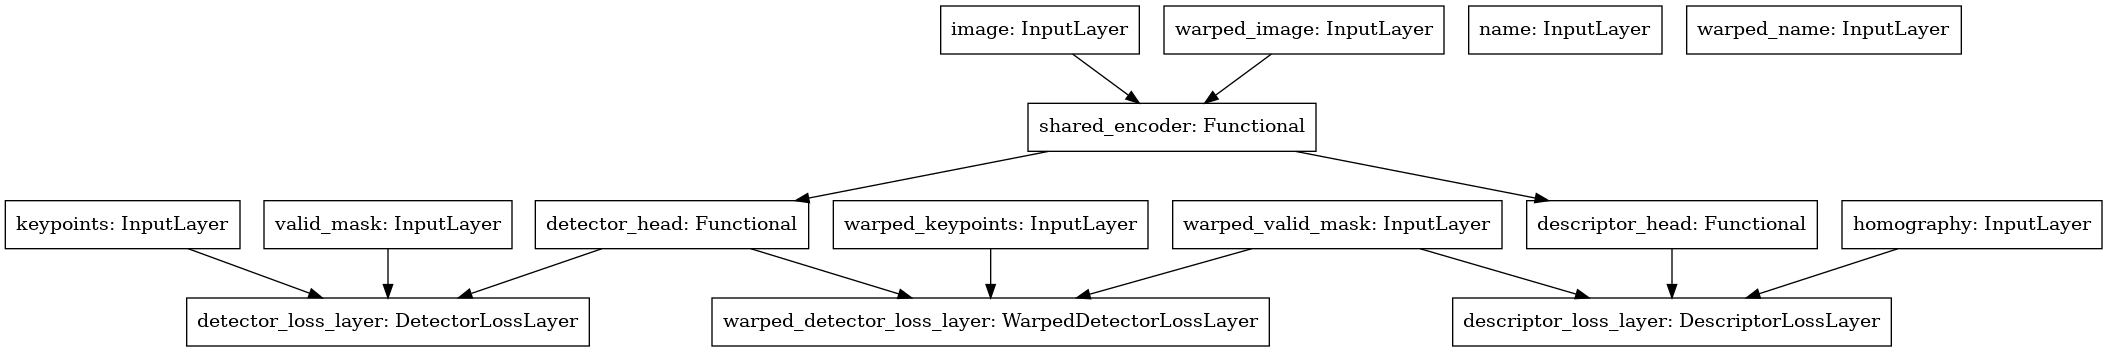

In [20]:
# model.summary()
keras.utils.plot_model(model, to_file="model.png", show_shapes=False, show_dtype=False, show_layer_names=True,
    rankdir="TB", expand_nested=False, dpi=96)

In [21]:
def detect_loss(dummy_target, y_pred):
#     return tf.squeeze(y_pred)
    return y_pred

def warped_detect_loss(dummy_target, y_pred):
#     return tf.squeeze(y_pred)
    return y_pred

def descript_loss(dummy_target, y_pred):
#     return tf.squeeze(y_pred)
    return y_pred

def dummy_metrics(dummy_target, y_pred):
#     return tf.squeeze(y_pred)
    return y_pred

def dummy_metrics1(dummy_target, y_pred):
#     return tf.squeeze(y_pred)
    return y_pred

model.compile(optimizer = keras.optimizers.Adam(learning_rate = model_config['learning_rate']),
              loss = [detect_loss, warped_detect_loss, descript_loss],
             loss_weights=[1., 1., 1.])
#                        metrics = [model_metrics, dummy_metrics, dummy_metrics1])

In [22]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        # The saved model name will include the current epoch.
        filepath="/root/Internship-Valeo/Project/results/superpoint070422_{epoch}",
        save_best_only=True,  # Only save a model if `val_loss` has improved.
        monitor="val_loss",
        verbose=1,)

TerminateOnNaN = tf.keras.callbacks.TerminateOnNaN()

In [23]:
# image_path_train = '/root/Internship-Valeo/Project/data/COCO/anntrain2014'
# point_path_train = '/root/Internship-Valeo/Project/data/COCO/magic_point-coco-export/pointstrain2014'
# # homography_path_train = '/root/Internship-Valeo/Project/data/COCO/homographies_train'

# # warped_image_path_train = '/root/Internship-Valeo/Project/data/COCO/warptrain2014'
# # warped_point_path_train = '/root/Internship-Valeo/Project/data/COCO/warped_pointstrain2014'


In [24]:
# train_gen = DataGen(image_path = image_path_train, point_path = point_path_train, 
# #                    homography_path = homography_path_train,  
# #                    warped_image_path = warped_image_path_train, warped_point_path = warped_point_path_train, 
                    
#                  image_size_x = 320, image_size_y = 240,
#                  is_training = True, batch_size = model_config['batch_size'])


# train_steps =  len(os.listdir(image_path_train))/model_config['batch_size']

In [25]:
# image_path_val = '/root/Internship-Valeo/Project/data/COCO/annval2014'
# point_path_val = '/root/Internship-Valeo/Project/data/COCO/pointsval2014'
# homography_path_val = '/root/Internship-Valeo/Project/data/COCO/homographies_val'

# warped_image_path_val = '/root/Internship-Valeo/Project/data/COCO/warpval2014'
# warped_point_path_val = '/root/Internship-Valeo/Project/data/COCO/warped_pointsval2014'

In [26]:
# val_gen = DataGen(image_path = image_path_val, point_path = point_path_val, 
#                    homography_path = homography_path_val, 
#                    warped_image_path = warped_image_path_val, warped_point_path = warped_point_path_val, 
                   
#                  image_size_x = 320, image_size_y = 240,
#                  is_training = True, batch_size = model_config['batch_size'])

In [27]:
train_image_path = DATA_PATH + '/COCO/anntrain2014'
train_gen = train_gen.repeat()
train_gen = train_gen.batch(model_config['batch_size'])
val_gen = val_gen.take(config['validation_size'])
val_gen = val_gen.batch(model_config['eval_batch_size'])

In [38]:
steps_per_epoch = len(os.listdir(train_image_path))//model_config['batch_size']
epochs = config1['train_iter']//steps_per_epoch
history = model.fit(x = train_gen, validation_data = val_gen, batch_size = model_config['batch_size'], 
                     steps_per_epoch = steps_per_epoch, epochs=epochs, 
                    callbacks=[model_checkpoint_callback, TerminateOnNaN, 
                        tensorboard_callback])

Epoch 1/26
22587/22587 [==============================] - 7848s 347ms/step - loss: 4.6787 - detector_loss_layer_loss: 0.0000e+00 - warped_detector_loss_layer_loss: 0.0000e+00 - descriptor_loss_layer_loss: 0.0000e+00 - detector_precision: 0.0178 - detector_recall: 0.1970 - warped_detector_precision: 0.0132 - warped_detector_recall: 0.1369 - val_loss: 2.7438 - val_detector_loss_layer_loss: 0.0000e+00 - val_warped_detector_loss_layer_loss: 0.0000e+00 - val_descriptor_loss_layer_loss: 0.0000e+00 - val_detector_precision: 0.0387 - val_detector_recall: 0.4067 - val_warped_detector_precision: 0.0240 - val_warped_detector_recall: 0.2476

Epoch 00001: val_loss improved from inf to 2.74377, saving model to /root/Internship-Valeo/Project/results/superpoint070422_1
INFO:tensorflow:Assets written to: /root/Internship-Valeo/Project/results/superpoint070422_1/assets
Epoch 2/26
22587/22587 [==============================] - 5220s 231ms/step - loss: 2.8575 - detector_loss_layer_loss: 0.0000e+00 - warpe


Epoch 00011: val_loss improved from 2.23019 to 2.18605, saving model to /root/Internship-Valeo/Project/results/superpoint070422_11
INFO:tensorflow:Assets written to: /root/Internship-Valeo/Project/results/superpoint070422_11/assets
Epoch 12/26
22587/22587 [==============================] - 4247s 188ms/step - loss: 2.5543 - detector_loss_layer_loss: 0.0000e+00 - warped_detector_loss_layer_loss: 0.0000e+00 - descriptor_loss_layer_loss: 0.0000e+00 - detector_precision: 0.1178 - detector_recall: 0.4275 - warped_detector_precision: 0.0629 - warped_detector_recall: 0.2567 - val_loss: 2.2344 - val_detector_loss_layer_loss: 0.0000e+00 - val_warped_detector_loss_layer_loss: 0.0000e+00 - val_descriptor_loss_layer_loss: 0.0000e+00 - val_detector_precision: 0.1516 - val_detector_recall: 0.5750 - val_warped_detector_precision: 0.1155 - val_warped_detector_recall: 0.3408

Epoch 00012: val_loss did not improve from 2.18605
Epoch 13/26
22587/22587 [==============================] - 4244s 188ms/step -

22587/22587 [==============================] - 4537s 201ms/step - loss: 2.5155 - detector_loss_layer_loss: 0.0000e+00 - warped_detector_loss_layer_loss: 0.0000e+00 - descriptor_loss_layer_loss: 0.0000e+00 - detector_precision: 0.1245 - detector_recall: 0.4382 - warped_detector_precision: 0.0662 - warped_detector_recall: 0.2622 - val_loss: 2.1996 - val_detector_loss_layer_loss: 0.0000e+00 - val_warped_detector_loss_layer_loss: 0.0000e+00 - val_descriptor_loss_layer_loss: 0.0000e+00 - val_detector_precision: 0.1726 - val_detector_recall: 0.5965 - val_warped_detector_precision: 0.1395 - val_warped_detector_recall: 0.3567

Epoch 00023: val_loss did not improve from 2.17830
Epoch 24/26
22587/22587 [==============================] - 4279s 189ms/step - loss: 2.5124 - detector_loss_layer_loss: 0.0000e+00 - warped_detector_loss_layer_loss: 0.0000e+00 - descriptor_loss_layer_loss: 0.0000e+00 - detector_precision: 0.1248 - detector_recall: 0.4384 - warped_detector_precision: 0.0667 - warped_detec

In [39]:
# model.save('/root/Internship-Valeo/Project/results/checkpoint-superpoint-coco-07042022')

INFO:tensorflow:Assets written to: /root/Internship-Valeo/Project/results/checkpoint-superpoint-coco-07042022/assets


In [ ]:
# model.load_weights('/root/Internship-Valeo/Project/results/checkpoint-superpoint-coco')

In [28]:
x = iter(train_gen).get_next()

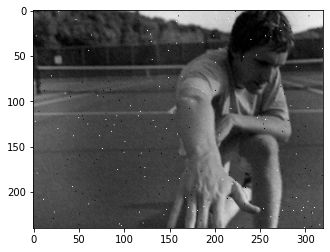

In [29]:
plt.imshow(x['image'][0], cmap = 'gray')

In [30]:
x['name'][0]

<tf.Tensor: shape=(), dtype=string, numpy=b'COCO_train2014_000000533809'>

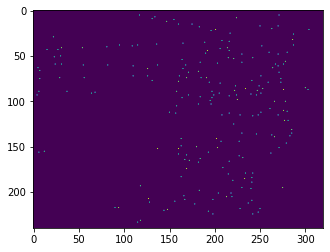

In [31]:
plt.imshow(x['keypoints'][0])

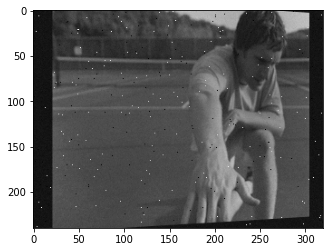

In [32]:
plt.imshow(x['warped']['image'][0], cmap = 'gray')

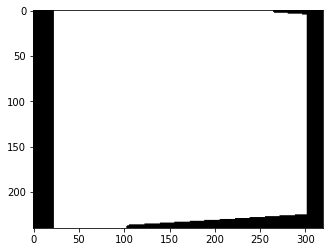

In [33]:
plt.imshow(x['warped']['valid_mask'][0], cmap = 'gray')

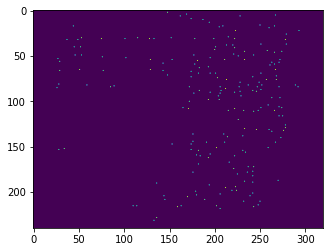

In [34]:
plt.imshow(x['warped']['keypoints'][0])

In [35]:
x['warped']['homography'][0]

<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([ 9.6381223e-01,  3.7608564e-07, -2.0689209e+01, -6.0180530e-02,
        9.1209018e-01,  1.5683555e+01, -4.8092814e-04,  1.9822055e-09],
      dtype=float32)>

In [36]:
x['warped']['name']

<tf.Tensor: shape=(2,), dtype=string, numpy=
array([b'COCO_train2014_000000533809', b'COCO_train2014_000000452236'],
      dtype=object)>

In [40]:
model.predict(x)

[0.5543729662895203, 0.8518601655960083, 0.9393212795257568]